In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_validate
import tqdm

In [9]:
from hyperopt.pyll import scope as ho_scope
from hyperopt import fmin, tpe, hp

### Prepare data

In [10]:
def get_data():
    file = open('./data/shashlik_61_pulses.txt', 'r')
    data = file.readlines()
    data = np.array([list(map(float, experiment.split())) for experiment in data])
   
    X = data[:, 2:]
    y_baseline = data[:, 1]
    y = data[:, 0]
    
    
    X = np.array([experiment - np.max(experiment) for experiment in X])
    X = np.array([experiment/-np.min(experiment) for experiment in X])

    y = np.round(y)
    y = y.astype(int)
    
    ## Let's shift each signal so that reference time matches for each signal
    mean_ref_time = int(y.mean())
    X = np.array([signal_cyclic_shift(signal, mean_ref_time - y[i]) for i, signal in enumerate(X, 0)])
    y = np.array([mean_ref_time]*len(y))

    return X, y

def get_freq_data(X, freq=1, start_point=384):
    X_freq = np.concatenate([X[:, start_point::-freq][:, ::-1], X[:, start_point + freq::freq]], axis=1)
    return X_freq

def signal_cyclic_shift(signal, tau):
    signal_start = signal[:-tau]
    
    new_signal = np.concatenate([signal[-tau:], signal_start])
    
    return new_signal

In [11]:
X_origin, y_origin = get_data()

mean_argmin =  int(np.argmin(X_origin, axis=1).mean())

In [12]:
def get_ref_time(first_impulse, second_impulse, first_ref_time, second_ref_time):
    if np.min(first_impulse) < np.min(second_impulse):
         return first_ref_time
    else:
        return second_ref_time

In [13]:
import random

def generate_multi_signal(X_origin, y_origin, tau, alpha, to_plot=False):
    first_idx, second_idx = np.random.choice(X_origin.shape[0], 2, replace=False)
    first_impulse = X_origin[first_idx]
    second_impulse = X_origin[second_idx]
    
    first_ref_time = y_origin[first_idx]
    second_ref_time = y_origin[second_idx]
    
    
#     print("SHIFT:", tau)
#     print("BEFORE SHIFT:", first_ref_time, second_ref_time)
    ### Randomly choose what signal to shift
    if random.choice([True, False]):
        first_impulse = signal_cyclic_shift(first_impulse, tau)
        first_ref_time += tau
    else:
        second_impulse = signal_cyclic_shift(second_impulse, tau)
        second_ref_time += tau
    
#     print("AFTER SHIFT:", first_ref_time, second_ref_time)
    
    multi_impulse = first_impulse + second_impulse*alpha
    multi_impulse /= -np.min(multi_impulse)
    
    first_impulse_shifted = signal_cyclic_shift(first_impulse, mean_argmin - np.argmin(first_impulse))
    second_impulse_shifted = signal_cyclic_shift(second_impulse, mean_argmin - np.argmin(second_impulse))
    multi_impulse_shifted = signal_cyclic_shift(multi_impulse, mean_argmin - np.argmin(multi_impulse))

#     print(mean_argmin - np.argmin(multi_impulse))
    first_ref_time +=  mean_argmin - np.argmin(multi_impulse)
    second_ref_time +=  mean_argmin - np.argmin(multi_impulse)
    
    if to_plot:
        plt.plot(first_impulse)
        plt.plot(second_impulse)
        plt.plot(multi_impulse_shifted)
        plt.legend(['First signal', 'Second signal', 'Sum of signals'])
        plt.show()
        
    ref_time = get_ref_time(first_impulse, second_impulse*alpha, first_ref_time, second_ref_time)
    
    return {'first_impulse': first_impulse_shifted,\
            'second_impulse': second_impulse_shifted,\
            'ref_time': ref_time,\
            'multi_impulse': multi_impulse_shifted}

In [ ]:
from sklearn.utils import shuffle

def prepare_data(X_origin, y_origin, tau_range, alpha_range, data_size=1000, to_print=False):    
    X = []
    y = []
    alpha_values = []
    tau_values = []
    for i in range(data_size):
        alpha = random.choice(alpha_range)
        tau = random.choice(tau_range)
        signal = generate_multi_signal(X_origin, y_origin, tau, alpha)
        
        
        X.append(signal['multi_impulse'])
        y.append(signal['ref_time']) ### We have alpha >= 1 so second_ref_time always will be close to 167,
                                           ### so we will predict first_ref_time
        
        alpha_values.append(alpha)
        tau_values.append(tau)
   
    X = np.array(X)
    y = np.array(y)
    
    if to_print:
        print("X shape:", X.shape)
        print("y shape:", y.shape)
    
    X, y = shuffle(X, y)

#     plt.scatter(alpha_values, tau_values)
#     plt.show()
    
    return X, y

In [ ]:
# alpha_range = np.array([np.around(10**i, decimals=4) for i in np.arange(0, 3.1, 0.01)])
alpha_range = np.array([np.around(10**i, decimals=4) for i in np.arange(-3, 3.1, 0.1)])
tau_range = np.arange(-100, 101, 1)

In [ ]:
X, y = prepare_data(X_origin, y_origin, tau_range, alpha_range, data_size=100, to_print=True)

X shape: (100, 1024)
y shape: (100,)


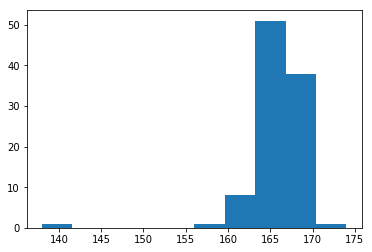

In [ ]:
plt.hist(y)
plt.show()

### Hyperopt

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import HuberRegressor
from sklearn import linear_model
from sklearn import tree
from sklearn import svm
from sklearn.linear_model import PassiveAggressiveRegressor
import xgboost as xgb
from catboost import CatBoostRegressor

##### Huber

In [ ]:
def f(space):
    huber_reg = HuberRegressor(epsilon=space['epsilon'], max_iter=space['max_iter'], alpha=space['alpha'])
    scores = cross_validate(huber_reg, X, y, scoring='neg_mean_absolute_error', cv=5)
    return -scores['test_score'].mean()
    
space = {
    'epsilon':  hp.loguniform('epsilon', low=np.log(1.1), high=np.log(10)),
    'max_iter': ho_scope.int(hp.quniform('max_iter', low=100, high=500, q=10)),
    'alpha':  hp.loguniform('alpha', low=np.log(0.0001), high=np.log(0.01)),
}

best = fmin(
    fn=f,  # "Loss" function to minimize
    space=space,  # Hyperparameter space
    algo=tpe.suggest,  # Tree-structured Parzen Estimator (TPE)
    max_evals=500  # Perform 100 trials
)

print("Found minimum after 100 trials:")
print(best)

100%|██████████| 500/500 [23:11<00:00,  3.91s/it, best loss: 1.0587785976612172]
Found minimum after 100 trials:
{'alpha': 0.00998778547224398, 'epsilon': 1.242032186307099, 'max_iter': 410.0}


#### Ridge

In [ ]:
def f(space):
    ridge_reg = linear_model.Ridge(solver=space['solver'], max_iter=space['max_iter'], alpha=space['alpha'])
    scores = cross_validate(ridge_reg, X, y, scoring='neg_mean_absolute_error', cv=5)
    return -scores['test_score'].mean()
    
space = {
    'solver': hp.choice('solver', ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']),
    'max_iter': ho_scope.int(hp.quniform('max_iter', low=1000, high=5000, q=100)),
    'alpha':  hp.loguniform('alpha', low=np.log(0.0001), high=np.log(1)),
}

best = fmin(
    fn=f,  # "Loss" function to minimize
    space=space,  # Hyperparameter space
    algo=tpe.suggest,  # Tree-structured Parzen Estimator (TPE)
    max_evals=500  # Perform 100 trials
)

print("Found minimum after 100 trials:")
print(best)

100%|██████████| 500/500 [02:19<00:00,  5.32it/s, best loss: 1.2577307742459154]
Found minimum after 100 trials:
{'alpha': 0.5134223164532016, 'max_iter': 3700.0, 'solver': 3}


#### Lasso

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def f(space):
    lasso_reg = linear_model.Lasso(max_iter=space['max_iter'], alpha=space['alpha'], normalize=space['normalize'])
    scores = cross_validate(lasso_reg, X, y, scoring='neg_mean_absolute_error', cv=5)
    return -scores['test_score'].mean()
    
space = {
    'normalize': hp.choice('normalize', [True, False]),
    'max_iter': ho_scope.int(hp.quniform('max_iter', low=1000, high=5000, q=100)),
    'alpha':  hp.loguniform('alpha', low=np.log(0.0001), high=np.log(1)),
}

best = fmin(
    fn=f,  # "Loss" function to minimize
    space=space,  # Hyperparameter space
    algo=tpe.suggest,  # Tree-structured Parzen Estimator (TPE)
    max_evals=500  # Perform 100 trials
)

print("Found minimum after 100 trials:")
print(best)

100%|██████████| 500/500 [04:37<00:00,  1.83it/s, best loss: 1.2567995430614787]
Found minimum after 100 trials:
{'alpha': 0.008499157214207619, 'max_iter': 4700.0, 'normalize': 1}


#### Decision tree

In [ ]:
def f(space):
    dt_reg = tree.DecisionTreeRegressor(max_depth=space['max_depth'], min_samples_split=space['min_samples_split'],
                                       min_samples_leaf=space['min_samples_leaf'], min_weight_fraction_leaf=
                                        space['min_weight_fraction_leaf'], max_features=space['max_features'])
    scores = cross_validate(dt_reg, X, y, scoring='neg_mean_absolute_error', cv=5)
    return -scores['test_score'].mean()
    
space = {
    'max_depth':  ho_scope.int(hp.quniform('max_iter', low=4, high=100, q=2)),
    'min_samples_split': ho_scope.int(hp.quniform('min_samples_split', low=2, high=10, q=1)),
    'min_samples_leaf':  ho_scope.int(hp.quniform('min_samples_leaf', low=1, high=10, q=1)),
    'min_weight_fraction_leaf': hp.uniform('min_weight_fraction_leaf', 0, 0.5),
    'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2'])
}

best = fmin(
    fn=f,  # "Loss" function to minimize
    space=space,  # Hyperparameter space
    algo=tpe.suggest,  # Tree-structured Parzen Estimator (TPE)
    max_evals=500  # Perform 100 trials
)

print("Found minimum after 100 trials:")
print(best)

100%|██████████| 500/500 [00:41<00:00,  8.80it/s, best loss: 1.5376176601176594]
Found minimum after 100 trials:
{'max_features': 0, 'max_iter': 38.0, 'min_samples_leaf': 9.0, 'min_samples_split': 9.0, 'min_weight_fraction_leaf': 0.017959228408691214}


#### Passive aggresive

In [ ]:
def f(space):
    pa_reg = PassiveAggressiveRegressor(max_iter=space['max_iter'], tol=space['max_iter'], 
                                       C = space['C'])
    scores = cross_validate(pa_reg, X, y, scoring='neg_mean_absolute_error', cv=5)
    return -scores['test_score'].mean()
    
space = {
    'max_iter': ho_scope.int(hp.quniform('max_iter', low=1000, high=5000, q=100)),
    'tol': hp.loguniform('tol', low=np.log(0.000001), high=np.log(0.001)),
    'verbose': ho_scope.int(hp.quniform('verbose', low=1, high=100, q=2)),
    'C':  hp.loguniform('c', low=np.log(0.0001), high=np.log(10)),
}

best = fmin(
    fn=f,  # "Loss" function to minimize
    space=space,  # Hyperparameter space
    algo=tpe.suggest,  # Tree-structured Parzen Estimator (TPE)
    max_evals=500  # Perform 100 trials
)

print("Found minimum after 100 trials:")
print(best)

100%|██████████| 500/500 [00:38<00:00,  8.38it/s, best loss: 2.5793505639871768]
Found minimum after 100 trials:
{'c': 0.18503178295924097, 'max_iter': 1700.0, 'tol': 0.00015132248349779718, 'verbose': 66.0}


#### Xgboost

In [ ]:
def f(space):
    xgb_reg = xgb.XGBRegressor(objective="reg:linear", booster=space['booster'], eta=space['eta'], 
                               gamma=space['gamma'], max_depth=space['max_depth'], reg_lambda=space['lambda'],
                               alpha=space['alpha'], verbosity=0)
    scores = cross_validate(xgb_reg, X, y, scoring='neg_mean_absolute_error', cv=5)
    return -scores['test_score'].mean()
    
space = {
    'booster': hp.choice('booster', ['gbtree', 'gblinear', 'dart']),
    'eta': hp.loguniform('eta', low=np.log(0.001), high=np.log(1)),
    'gamma': hp.loguniform('gamma', low=np.log(0.001), high=np.log(100)),
    'max_depth': ho_scope.int(hp.quniform('max_depth', low=5, high=50, q=2)),
    'lambda': hp.loguniform('lambda', low=np.log(0.001), high=np.log(10)),
    'alpha':  hp.loguniform('alpha', low=np.log(0.001), high=np.log(10)),
}

best = fmin(
    fn=f,  # "Loss" function to minimize
    space=space,  # Hyperparameter space
    algo=tpe.suggest,  # Tree-structured Parzen Estimator (TPE)
    max_evals=500  # Perform 100 trials
)

print("Found minimum after 100 trials:")
print(best)

 77%|███████▋  | 383/500 [35:08<14:27,  7.41s/it, best loss: 1.6928302001953124]